In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

Using device:  cuda


In [2]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import os
import time

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = "/content/drive/MyDrive/RecycleVision/datas/garbage-dataset"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                         std = [0.229,0.224,0.225])
])

#loading data and spliiting it
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

val_dataset.dataset.transform = val_transform



#dataloaders
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))

Train batches: 495
Validation batches: 8


In [4]:
def train_an_epoch(model, dataloader, criterion, optimizer,device):
  model.train()
  running_loss, correct, total = 0.0,0,0
  batch = 0

  for batch_idx, (images, labels) in enumerate(dataloader, start=1):

    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)


    if batch_idx ==1:
      print(f"{batch_idx} started")
    elif batch_idx ==2:
      print(f"{batch_idx} started")
    elif batch_idx ==3:
      print(f"{batch_idx} started")
    elif batch_idx % 32 == 0:  # every 32 batches
      print(f"  [Batch {batch_idx}/{len(dataloader)}] running...")

  epoch_loss = running_loss/total
  epoch_acc = correct/total
  return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
  model.eval()
  running_loss, correct, total = 0.0,0,0

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * images.size(0)
      _,preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total+= labels.size(0)

    epoch_loss = running_loss /total
    epoch_acc = correct/total
    return epoch_loss, epoch_acc

In [18]:

class BaselineCNN(nn.Module):
  def __init__(self):

    super().__init__()

    self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride=1,padding=1) #32,224,224
    self.pool = nn.MaxPool2d(2,2)                 #32,112,112
    self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1) #64,112,112
    #after pooling 64,56,56
    self.conv3 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1) #128,56,56
    # after pooling 128, 28,28

    self.fc1 = nn.Linear(128*28*28, 256)
    self.fc2 = nn.Linear(256, 10)

    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.5)

  def forward(self, x):
    #conv1
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    #conv2 + relu + pool
    x = self.pool(self.relu(self.conv2(x)))

    #conv3 + relu + pool
    x = self.pool(self.relu(self.conv3(x)))

    #flatten
    x = x.view(-1, 128*28*28)

    #fc1+relu+dropout
    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)

    #output
    x=self.fc2(x)

    return x



#initializing model, loss, optimizer
model = BaselineCNN().to(device)

# compute class weights from dataset
labels = [label for _, label in full_dataset.samples]
class_counts = np.bincount(labels)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
# Sampler = works with NumPy/Python arrays → PyTorch converts internally.
# Loss function = strictly requires torch.Tensor on the right device.

# weighted loss (to handle imbalance)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = optim.Adam(model.parameters(), lr=0.001)

#


In [19]:
import time
#trainingLoop
epochs = 10
for epoch in range(epochs):

  train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)

  print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Batch 480/495] running...
Epoch [1/10] Train Loss: 1.7850, Train Acc: 0.3983 Val Loss: 1.4694, Val Acc: 0.5285
1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Batch 480/495] ru

KeyboardInterrupt: 

In [20]:
#resnet
from torchvision import models

class ResNet50_Custom(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    #loading pretained resnet50
    base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    #freeqzing all conv layers
    for param in base_model.parameters():
      param.requires_grad = False

    # Save in_features BEFORE replacing fc
    num_features = base_model.fc.in_features

    #keeping everything except the final fc layer
    self.features = base_model  #fullModel
    self.features.fc = nn.Identity()  #removed og fc

    #defining custom dense layers
    self.fc1 = nn.Linear(num_features, 512)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    #extracting features using resNet backbone
    x = self.features(x)  # output shape: (batch_size, 2048)

    #custom dense layers
    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.fc2(x)
    return x

model = ResNet50_Custom(num_classes=len(full_dataset.classes)).to(device)

labels = [label for _, label in full_dataset.samples]
class_counts = np.bincount(labels)
class_weights = torch.tensor(1.0/class_counts, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)




In [21]:
# Training loop
epochs = 10
for epoch in range(epochs):
  start = time.time()
  train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)


  duration = time.time() - start
  print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "
          f"Time: {duration:.2f}s")



1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Batch 480/495] running...
Epoch [1/10] Train Loss: 0.6251, Train Acc: 0.8149 Val Loss: 0.3490, Val Acc: 0.8978 Time: 146.31s
1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Bat

In [22]:
# Saving ResNet50 after training is done
torch.save(model.state_dict(), "/content/drive/MyDrive/RecycleVision/models/resnet50_best.pth")
print("ResNet50 model saved successfully!")

ResNet50 model saved successfully!


In [7]:
#efficientnetB0

class EfficientNetB0_Custom(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    for param in base_model.features.parameters():
      param.requires_grad = False

    num_features = base_model.classifier[1].in_features

    self.features = base_model.features

    #custom
    self.fc1 = nn.Linear(num_features, 256)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, num_classes)

  def forward(self, x):
    #backbone
    x = self.features(x)     # (batch_size, 1280, 7, 7)
    x = x.mean([2,3])

    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)

    x = self.fc2(x)

    return x


#initi
model = EfficientNetB0_Custom(num_classes=len(full_dataset.classes)).to(device)

labels = [label for _, label in full_dataset.samples]
class_counts = np.bincount(labels)
class_weights = torch.tensor(1.0/class_counts, dtype = torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


In [8]:
# Training loop
epochs = 10
for epoch in range(epochs):
    start = time.time()

    train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    duration = time.time() - start
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "
          f"Time: {duration:.2f}s")

1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Batch 480/495] running...
Epoch [1/10] Train Loss: 0.6503, Train Acc: 0.8186 Val Loss: 0.3511, Val Acc: 0.8955 Time: 145.02s
1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Bat

In [14]:
#googlenet

class GoogleNet_Custom(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    base_model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1, aux_logits = True)

    # Disable auxiliary classifiers so they don’t affect forward()
    base_model.aux1 = nn.Identity()
    base_model.aux2 = nn.Identity()

    for param in base_model.parameters():
      param.requires_grad = False

    num_features = base_model.fc.in_features

    self.features = base_model
    self.features.fc = nn.Identity()

    self.fc1 = nn.Linear(num_features, 256)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, num_classes)

  def forward(self, x):

    x = self.features(x)    #(batchsize,1024)

    # If aux_logits=True, GoogLeNet returns a tuple-like object
    if isinstance(x, tuple) or hasattr(x, "logits"):
        x = x.logits

    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)

    x =self.fc2(x)

    return x


#ini
model = GoogleNet_Custom(num_classes=len(full_dataset.classes)).to(device)

labels = [label for _, label in full_dataset.samples]
class_counts = np.bincount(labels)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)





In [15]:
# Training loop
epochs = 10
for epoch in range(epochs):
    start = time.time()

    train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    duration = time.time() - start
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "
          f"Time: {duration:.2f}s")

1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Batch 480/495] running...
Epoch [1/10] Train Loss: 0.7721, Train Acc: 0.7760 Val Loss: 0.3970, Val Acc: 0.8867 Time: 168.52s
1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Bat

In [16]:
#vgg16
class VGG16_Custom(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_Custom, self).__init__()

        # Load pretrained VGG16
        base_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Freeze feature extractor
        for param in base_model.features.parameters():
            param.requires_grad = False

        # Get input features of classifier
        num_features = base_model.classifier[0].in_features

        # Replace classifier with custom dense head
        self.features = base_model.features
        self.avgpool = base_model.avgpool

        self.fc1 = nn.Linear(num_features, 256)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):     #Input: [32, 3, 224, 224]
        x = self.features(x)    #[32, 512, 7, 7]
        x = self.avgpool(x)     #[32, 512, 7, 7]
        x = torch.flatten(x, 1)   # flatten to (batch_size, num_features)-[32,25088]

        x = self.fc1(x) #32
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x


# Initialize model
model = VGG16_Custom(num_classes=len(full_dataset.classes)).to(device)

# Weighted loss
labels = [label for _, label in full_dataset.samples]
class_counts = np.bincount(labels)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
# Training loop
epochs = 10
for epoch in range(epochs):
    start = time.time()

    train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    duration = time.time() - start
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "
          f"Time: {duration:.2f}s")

1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Batch 480/495] running...
Epoch [1/10] Train Loss: 0.5998, Train Acc: 0.8334 Val Loss: 0.2944, Val Acc: 0.9084 Time: 166.31s
1 started
2 started
3 started
  [Batch 32/495] running...
  [Batch 64/495] running...
  [Batch 96/495] running...
  [Batch 128/495] running...
  [Batch 160/495] running...
  [Batch 192/495] running...
  [Batch 224/495] running...
  [Batch 256/495] running...
  [Batch 288/495] running...
  [Batch 320/495] running...
  [Batch 352/495] running...
  [Batch 384/495] running...
  [Batch 416/495] running...
  [Batch 448/495] running...
  [Bat

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


Classification Report:

              precision    recall  f1-score   support

     battery       0.93      0.97      0.95       183
  biological       0.95      0.96      0.96       213
   cardboard       0.94      0.90      0.92       372
     clothes       0.99      0.99      0.99      1054
       glass       0.96      0.85      0.90       627
       metal       0.78      0.89      0.83       215
       paper       0.90      0.89      0.90       321
     plastic       0.82      0.90      0.85       393
       shoes       0.97      0.97      0.97       392
       trash       0.81      0.88      0.84       183

    accuracy                           0.93      3953
   macro avg       0.91      0.92      0.91      3953
weighted avg       0.93      0.93      0.93      3953



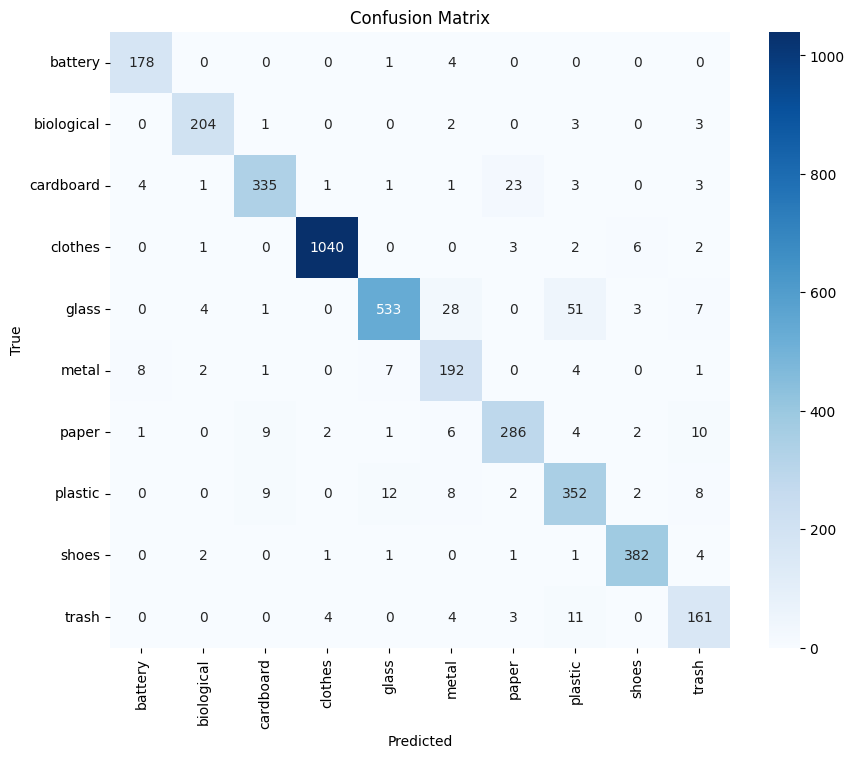

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reload saved ResNet50 model
best_model = ResNet50_Custom(num_classes=len(full_dataset.classes)).to(device)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/RecycleVision/models/resnet50_best.pth"))
best_model.eval()

y_true, y_pred = [], []

# Run inference on validation set
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


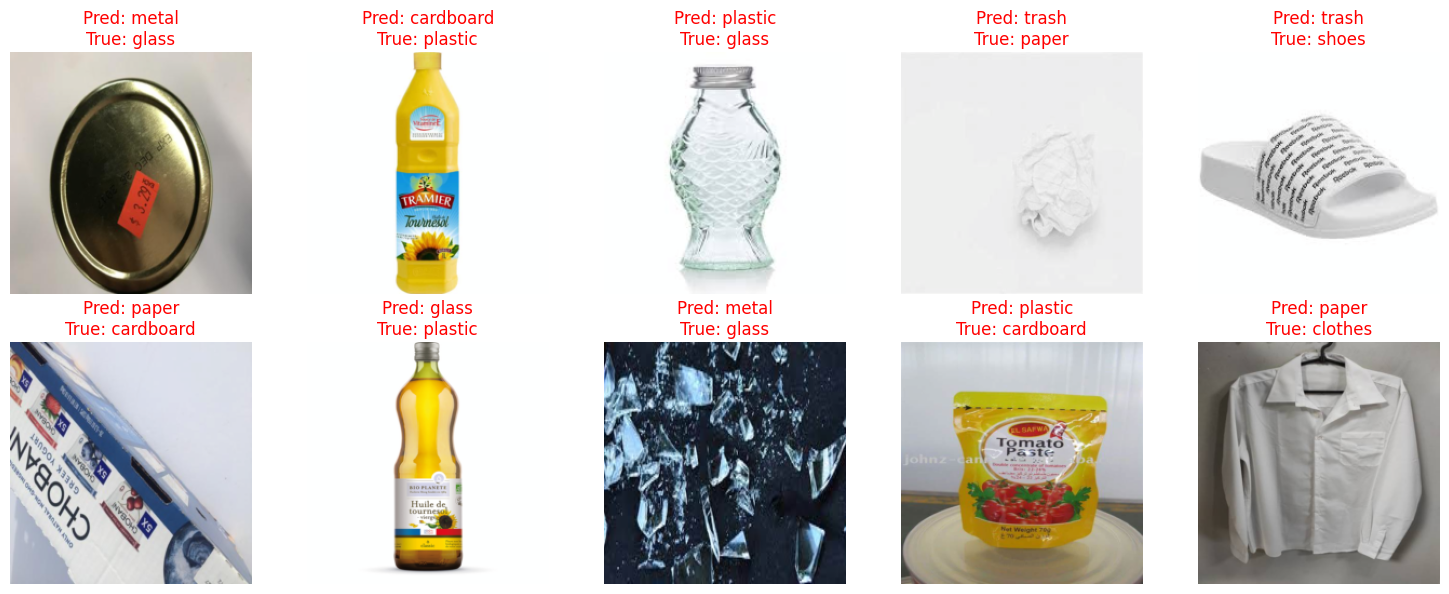

In [24]:
# Show misclassified images
import random

best_model.eval()
misclassified = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        # Find where predictions != labels
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

# Pick 10 random misclassified images
samples = random.sample(misclassified, 10)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (img, pred, true) in zip(axes.flat, samples):
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)

    ax.imshow(img)
    ax.set_title(f"Pred: {full_dataset.classes[pred]}\nTrue: {full_dataset.classes[true]}", color="red")
    ax.axis("off")

plt.tight_layout()
plt.show()


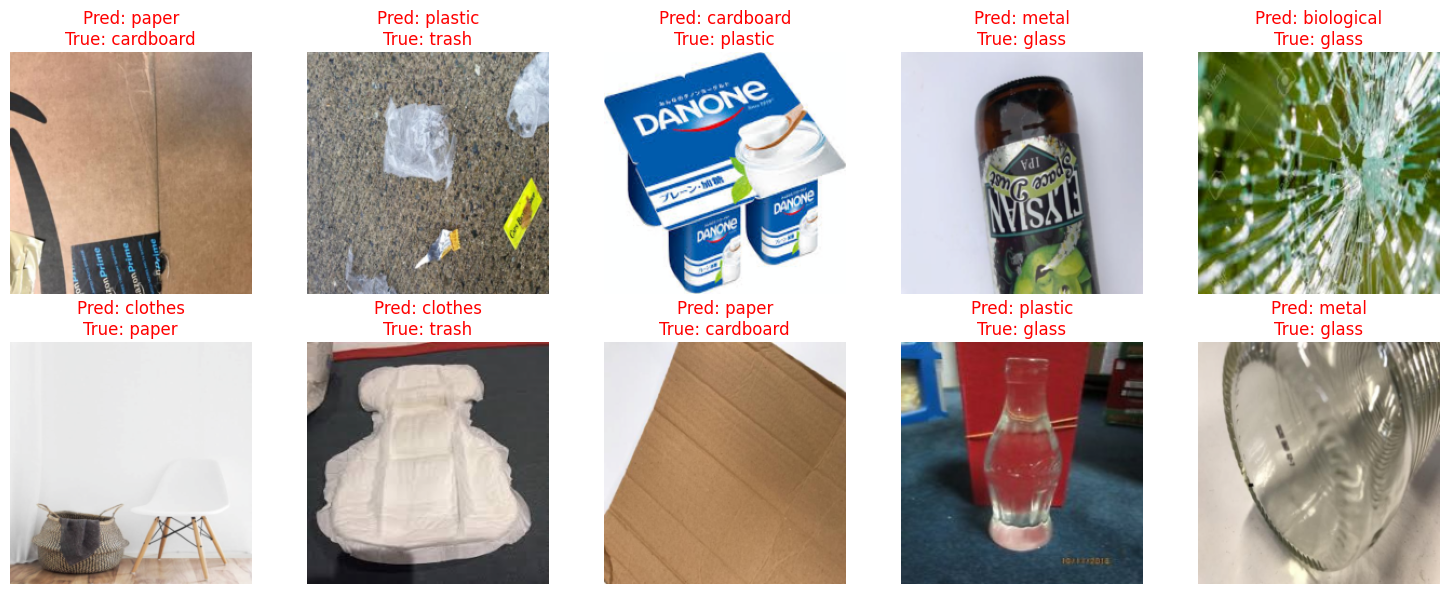

In [25]:
# Show misclassified images
import random

best_model.eval()
misclassified = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        # Find where predictions != labels
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

# Pick 10 random misclassified images
samples = random.sample(misclassified, 10)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (img, pred, true) in zip(axes.flat, samples):
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)

    ax.imshow(img)
    ax.set_title(f"Pred: {full_dataset.classes[pred]}\nTrue: {full_dataset.classes[true]}", color="red")
    ax.axis("off")

plt.tight_layout()
plt.show()


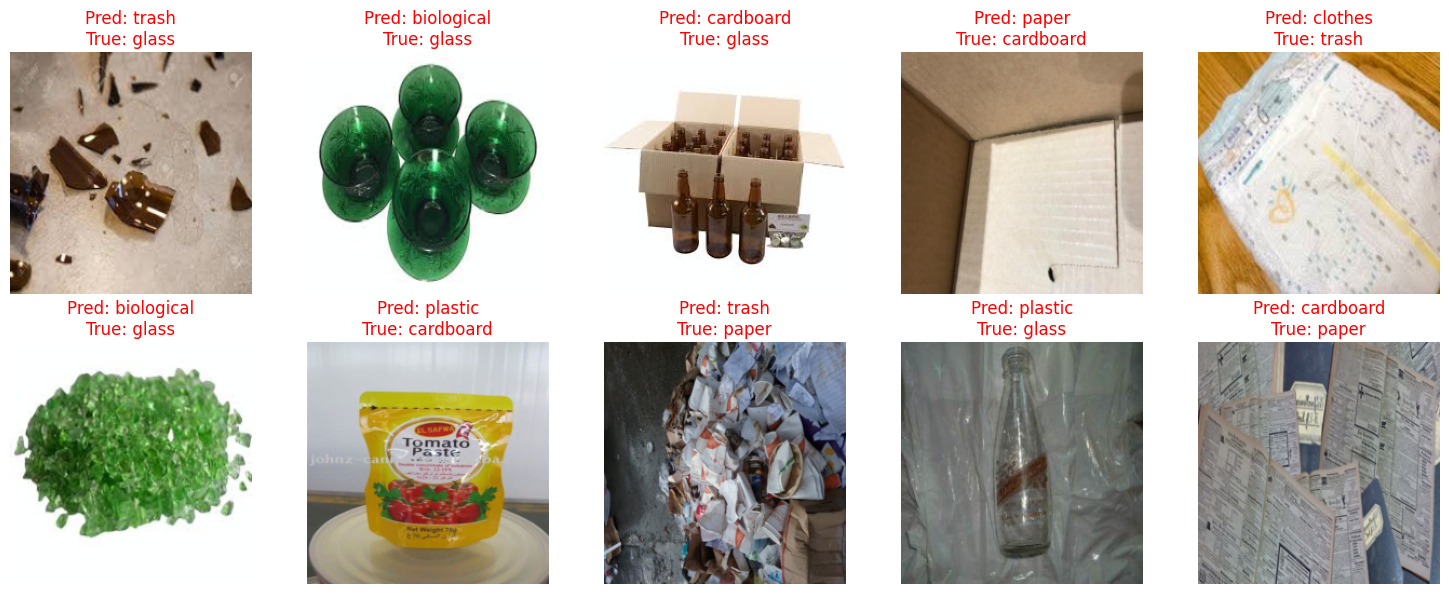

In [26]:
# Show misclassified images
import random

best_model.eval()
misclassified = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        # Find where predictions != labels
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))

# Pick 10 random misclassified images
samples = random.sample(misclassified, 10)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, (img, pred, true) in zip(axes.flat, samples):
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1)

    ax.imshow(img)
    ax.set_title(f"Pred: {full_dataset.classes[pred]}\nTrue: {full_dataset.classes[true]}", color="red")
    ax.axis("off")

plt.tight_layout()
plt.show()
